# Ethereum Fraudulent Transaction Classification

# 1. Project Overview

## 1.1 Motivation & Problem Definition

Over the past year, the mad rush of cryptocurrency has caught the attention of all kinds of investors. Not only that, it has also caught the attention of scammers. Crypto scams most often aim to trick a target victim into sending cryptocurrency to a compromised digital wallet. Through the use of dedicated social engineering, such as romance scams, email phishings, and even Ponzi schemes, these targets are very likely being convinced with the flourish returns promised by the attackers.

With the goal of applying our security analyst skills into solving real-world problems, we intend to use the approach of supervised and unsupervised learnings, in building a classifier to identify fraudulent Ethereum transactions.

## 1.2 Data Overview

The experimenting dataset is an open-source, labeled dataset from Kraggle, Ethereum Fraud Detection Dataset, with around 9,000 samples. This dataset is highly imbalanced, dominated by normal transactions, and non-normally distributed across features. As for the missing samples, we fill them through the use of Etherscan, an analytic platform for querying any Ethereum blockchain transactions.

## 1.3 Models & Techniques

With our first intuition, we approach this classification problem by trying out the supervised models that we learned in class, Logistic Regression, Support Vector Machine, and Random Forest. For investigating how well the fraud classification performs under an unsupervised model, we also take the GMM into account. From our experiments, the supervised models indeed do better in predicting fraudulent transactions in general regardless of the use of  PCA.

# 2. System Approach 

## 2.1 Data Comprehension with domain-knowledge

In machine learning workflow, dimensity reduction is one of the important steps for machine learning workflow.  So before applying any machine learning algorithm, we usually need to select what features are important for model training. We used our domain knowledge to identify what features are not important and drop those features from the dataset. To understand what features are important we need to explore how the kaggle ethereum dataset is constructed. In the following section we will explore most features defined in the dataset.

Ethereum is a decentralized, open-source blockchain with smart contract functionality and Ether is native cryptocurrency of the platform. Ethereum was conceived in 2013 by programmer Vitalik Buterin who was just 18 years old at the time of the creation of Ethereum blockchain. Ethereum is different from other traditional cryptocurrencies such as bitcoin because it supports smart contracts and it is turing complete. In other words, programmers and developers can write a program on ethereum blockchain and it can execute the program in a decentralized way. A "smart contract" is simply a program that runs on the Ethereum blockchain. It's a collection of code (its functions) and data (its state) that resides at a specific address on the Ethereum blockchain. Smart contracts are also a type of ethereum account which means it can send and receive tokens based on code written in it. But one of the biggest issues with smart contracts in the real world is that once it is deployed on the Ethereum block chain, smart contracts become immutable and can be abused by bad actors. Anyone in the world can see the code inside smart contracts. So we can use real time processing to identify the fraud transactions on the ethereum blockchain. On the Ethereum blockchain, a transaction is an event and it can be many things such as transferring ether tokens from one account to another or it can contain smart contracts. Now with our preliminary knowledge of ethereum, let’s look at the features defined in dataset:

- Address - It is a reference number for parties involved in the transaction created whenever a transaction is initiated on the Ethereum blockchain. We use etherscan.io to get details about any particular transaction. We also used this hash to fetch other columns to fill missing data as well as to confirm some of the data available in the dataset. These data is  not important for training as it would different for every transaction and we already have other features derived from address by fetching them from etherscan.io

- The next few columns measure the time difference between transactions like average mins between transactions and the time difference between the first and last transaction. Examples of such as columns are Avg min between sent tnx, Avg min between received tnx etc.

- Most of the other columns are related to ERC20 tokens. ERC-20 has emerged as the technical standard; it is used for all smart contracts on the Ethereum blockchain for token implementation and provides a list of rules that all Ethereum-based tokens must follow. ERC-20 is similar, in some respects, to bitcoin, Litecoin, and any other cryptocurrency; ERC-20 tokens are blockchain-based assets that have value and can be sent and received. The primary difference is that instead of running on their own blockchain, ERC-20 tokens are issued on the Ethereum network. The ERC-20 commands vital importance; it defines a common list of rules that all Ethereum tokens must adhere to. Some of these rules include how the tokens can be transferred, how transactions are approved, how users can access data about a token, and the total supply of tokens.

- There are two columns ERC20 Most Sent Token Type and ERC20 Most Received Token Type which contains categorical data about the majority of types of token sent or received in the transaction. We dropped the categorical data as Liverpool token which constituted a large share of values that had an equal number of fraud and valid transactions, this led us to believe that using the categorical data would heavily bias our data. Another great example is blockwell.ai - Blockwell.ai has an advanced system for flagging fraudulent transactions associated with known bank accounts. Because of their size they also have an equal number of valid transactions, but the data differentiates between them marking them differently. If we make both of them equal we basically lose the essence of the data. As any ERC token type is yet to be found by the malicious cos of the active community behind it, any fraudulent token type is never adopted. It's kinda survival of the fittest. The second option was to convert it to numerical data, but as the relation does not hold true i.e old token type is not better than the other. Because of the small dataset of fraud transactions and the heavy bias due to categorical data we decided to drop it.

In summary, by using our domain knowledge regarding ethereum blockchain and smart contracts, we decided to drop address, ERC20 Most Sent Token Type and ERC20 Most Received Token Type columns.


## 2.2. Data Exploration with plots

In comprehending the data characteristics thoroughly, we use tools like pie charts, heatmaps, correlation-matrix, and bot plots. 

- First, we approach the target feature by plotting it with a pie chart. Since there is around 20% of fraud data only, we decide to use cross validations in training in order to preserve the limited data and maximize model performance.

- Second, we use heat-maps in visualizing missing data. From its plotting, we find that around a half of the features contain missing records. To handle the insufficient entries, we fill the missing field with Ethescan and remove the row record entirely if it contains NaN data. 

- Thirdly, we use correlation matrix in learning correlations between each feturess. Since there are 50 features in the raw data, we remove 6 of them which have correlation values greater than 0.95. 

- Lastly, we apply box plots in learning the data distributions across different features. As a result, most of the features data are located tightly near the lower abound and scattered out as they approach the upper bound. With this non-normally distributed characteristic, we hypothesize that the GMM trials should not yield very good prediction results in comparison to other models.

## 2.3 Feature Reduction - PCA

Since the experiment dataset has arounds 40 features left still, after some feature removals (done in the above investigations) based on data comprehension and exploration, we decide to further compress its feature space by PCA. Using the PCA as a step of model optimization, we  compare mode performance obtained before and after the feature reduction respective to each model used.

# 3. Model Experiments

## 3.1 Tranning Preparation

We need to split our data into training, validation and test based on the model we are using. This is one of the important aspects of machine learning algorithms as data characteristic majorly impacts the model performance. For example, if our data is unbalanced then running supervised learning algorithms such as decision trees for anomaly detection without any k-fold validation would give rise to incorrect model evaluation because there is not enough anomaly data available. 

In our case, the dataset is also highly unbalanced (85% legitimate + 15% fraudulent). We are going to use the following methods to correctly handle the unbalanced data.
Synthetic Minority Oversampling Technique (SMOTE) - It is an oversampling technique that would make unbalanced data into balanced data. We are not going to discuss technical aspects of the SMOTE algorithm, we used this algorithm as black box algorithm that would make our unbalanced data into balanced data.
3-way Validation - We used 3-way validation in the GMM model to properly handle the unbalanced data. We split our normal data into 80% + 10% + 10% and anomaly data into 50% + 50%. Now, we treated 80% of normal data as training data and then we used 10% normal data + 50% anomaly data as validation data. We used validation data to get the optimal threshold for the GMM model and then we used the remaining remaining data (10% normal data and 50% of anomaly data) as test data to evaluate the GMM model.
K-fold validation - We used k-fold validation with our every supervised learning algorithm such as Random Forest, Support Vector Machine and Logistic regression to handle our unbalanced dataset.

## 3.2 Model Evaluations

| Model Name | Support Vector Machine | Logistic Regression | Random Forest | GMM   |
|------------|------------------------|---------------------|---------------|-------|
| F1 Score   | 0.765                  | 0.732               | 0.972         | 0.638 |
| Accuracy   | 0.723                  | 0.684               | 0.987         | 0.468 |
| AURPC      | 0.833                  | 0.754               | 0.995         | -     |

After all data cleaning and data preparation steps, we ran the supervised algorithm such as support vector machine (SVM), Logistic Regression, Random Forest as well as semi supervised algorithm such as Gaussian Mixture Model. The following table contains the results derived from each algorithm on data containing all the features after data cleaning.

From the table we can see that the Random Forest algorithm is the best performing algorithm with the highest F1 score (97%) as well as Accuracy and AURPC but let’s see if we can improve our model performance with reducing the feature. We used the PCA algorithm to reduce the features to 10 features. We again ran all the models on PCA and tried to look at the performance of each model.

| Model Name | Support Vector Machine | Logistic Regression | Random Forest | GMM   |
|------------|------------------------|---------------------|---------------|-------|
| F1 Score   | 0.989                  | 0.959               | 0.992         | 0.98  |
| Accuracy   | 0.989                  | 0.960               | 0.995         | 0.966 |
| AURPC      | 0.998                  | 0.971               | 0.999         | -     |

From the table we can see that the Random Forest algorithm is still the best performing algorithm with the highest F1 score (99%) as well as Accuracy and AURPC but we can see other algorithms such as logistic regression, support vector machine and GMM, model performance improved drastically. We got the F1 score in the high ninety range. And based on the performance of the model on PCA data, we can say that PCA indeed improves the result of all models by countering the issue of high dimensional data. 

# 4. Conclusions

## 4.1 Conclusions
In conclusion, as we anticipated, the supervised models performed better in general in comparison to the unsupervised model regardless of the use of PCA. Among the supervised models, random forest has the optimal performance with nearly 100% of f1-score and accuracy even before the feature reduction. 

As it has been presented, we attempted to apply a PowerTransformer to optimize the GMM model, but it does not yield better results in comparison to the use of PCA. From the GMM tuning, we learn that PCA is transforming our features in such a way that new features are more independent from one another (through linear combination) while the Power Transformer constructs feature normalization “locally” without considering other features.

## 4.2 Future Works

After removal of data in the data cleaning part, we end up with data only containing approximately 9000 rows and we believe this data is not enough for proper evaluation of our models. We can extend the current dataset by fetching data from etherscan.io and github repo that contains more fraudulent ethereum addresses and transactions.

Furthermore, we want to test out trained supervised learning algorithms on recent ethereum transactions and check if our model is able to identify the fraudulent transaction that is not already known to etherscan.io. 

# 5. Reference

1. [Ethereum Documentation](https://ethereum.org/en/developers/docs/)

2. [Scikit Learn Power Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)

3. [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

4. [Ethereum Fraud Dataset](https://www.kaggle.com/datasets/vagifa/ethereum-frauddetection-dataset)

# Experiment Execution Steps

# 1. Libaries

In [13]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix, precision_recall_curve, f1_score
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score
from sklearn.preprocessing import PowerTransformer

from models.EFM import Ethereum_Fraud_Model
from models.RF import Random_Forest_Model
from models.DBSCAN import DBSCAN_Model
from models.SVM import SVM_Model
from models.LR import Logistic_Regression_Model
from models.GMM import GMM_Model
from models.PCA import PCA_Transformer
from utils.correlation import get_top_abs_correlations

from config import *
from utils.cleaner import *

# 2. Data Reading

In [2]:
efm = Ethereum_Fraud_Model()
print(efm.df.shape)
display(efm.df.head())

(9841, 50)


,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
7727,66,0x07920356975798037f26a934db461c7aafc8aa05,1,272.57,1.46,1377.50,5,10,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
4499,1567,0x77899a51048d0a1340f0d48954e9d6716d4e8f5d,0,108.75,0.00,326.25,3,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
8241,580,0x414bca672494b8f078112c52ae258f9e8de1a4a0,1,0.00,2689.97,8069.90,0,3,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5844,2912,0x9c26000e299ce3898c08f9f4e7d3eb9801ae4ca2,0,162.16,0.33,324.97,2,2,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3648,716,0x60e2630f27e0cbccaa5174d84f14640127a18419,0,17.76,230.91,593171.90,2377,2386,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


# 3. Data Exploration

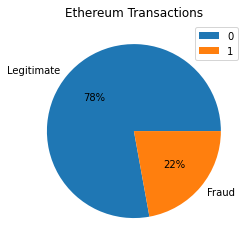

In [3]:
df = efm.df.copy()
flag_counts = df['FLAG'].value_counts()

plt.pie(flag_counts, labels={'Fraud', 'Legitimate'}, autopct='%.0f%%')
plt.title('Ethereum Transactions')
plt.legend(flag_counts.keys().tolist())
plt.show()

In [4]:
# Removing features based on Domain Understanding
df.drop(efm.filtered_colns, axis=1, inplace=True)

In [5]:
# Get features with 0 variance
no_var = df.var() == 0
print(df.var()[no_var])
print('\n')

 ERC20 avg time between sent tnx        0.0
 ERC20 avg time between rec tnx         0.0
 ERC20 avg time between rec 2 tnx       0.0
 ERC20 avg time between contract tnx    0.0
 ERC20 min val sent contract            0.0
 ERC20 max val sent contract            0.0
 ERC20 avg val sent contract            0.0
dtype: float64




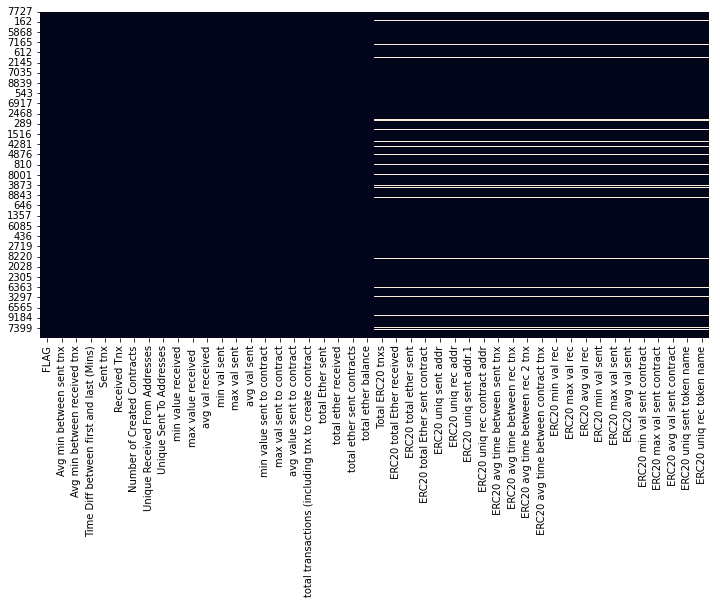

In [6]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

<AxesSubplot:>

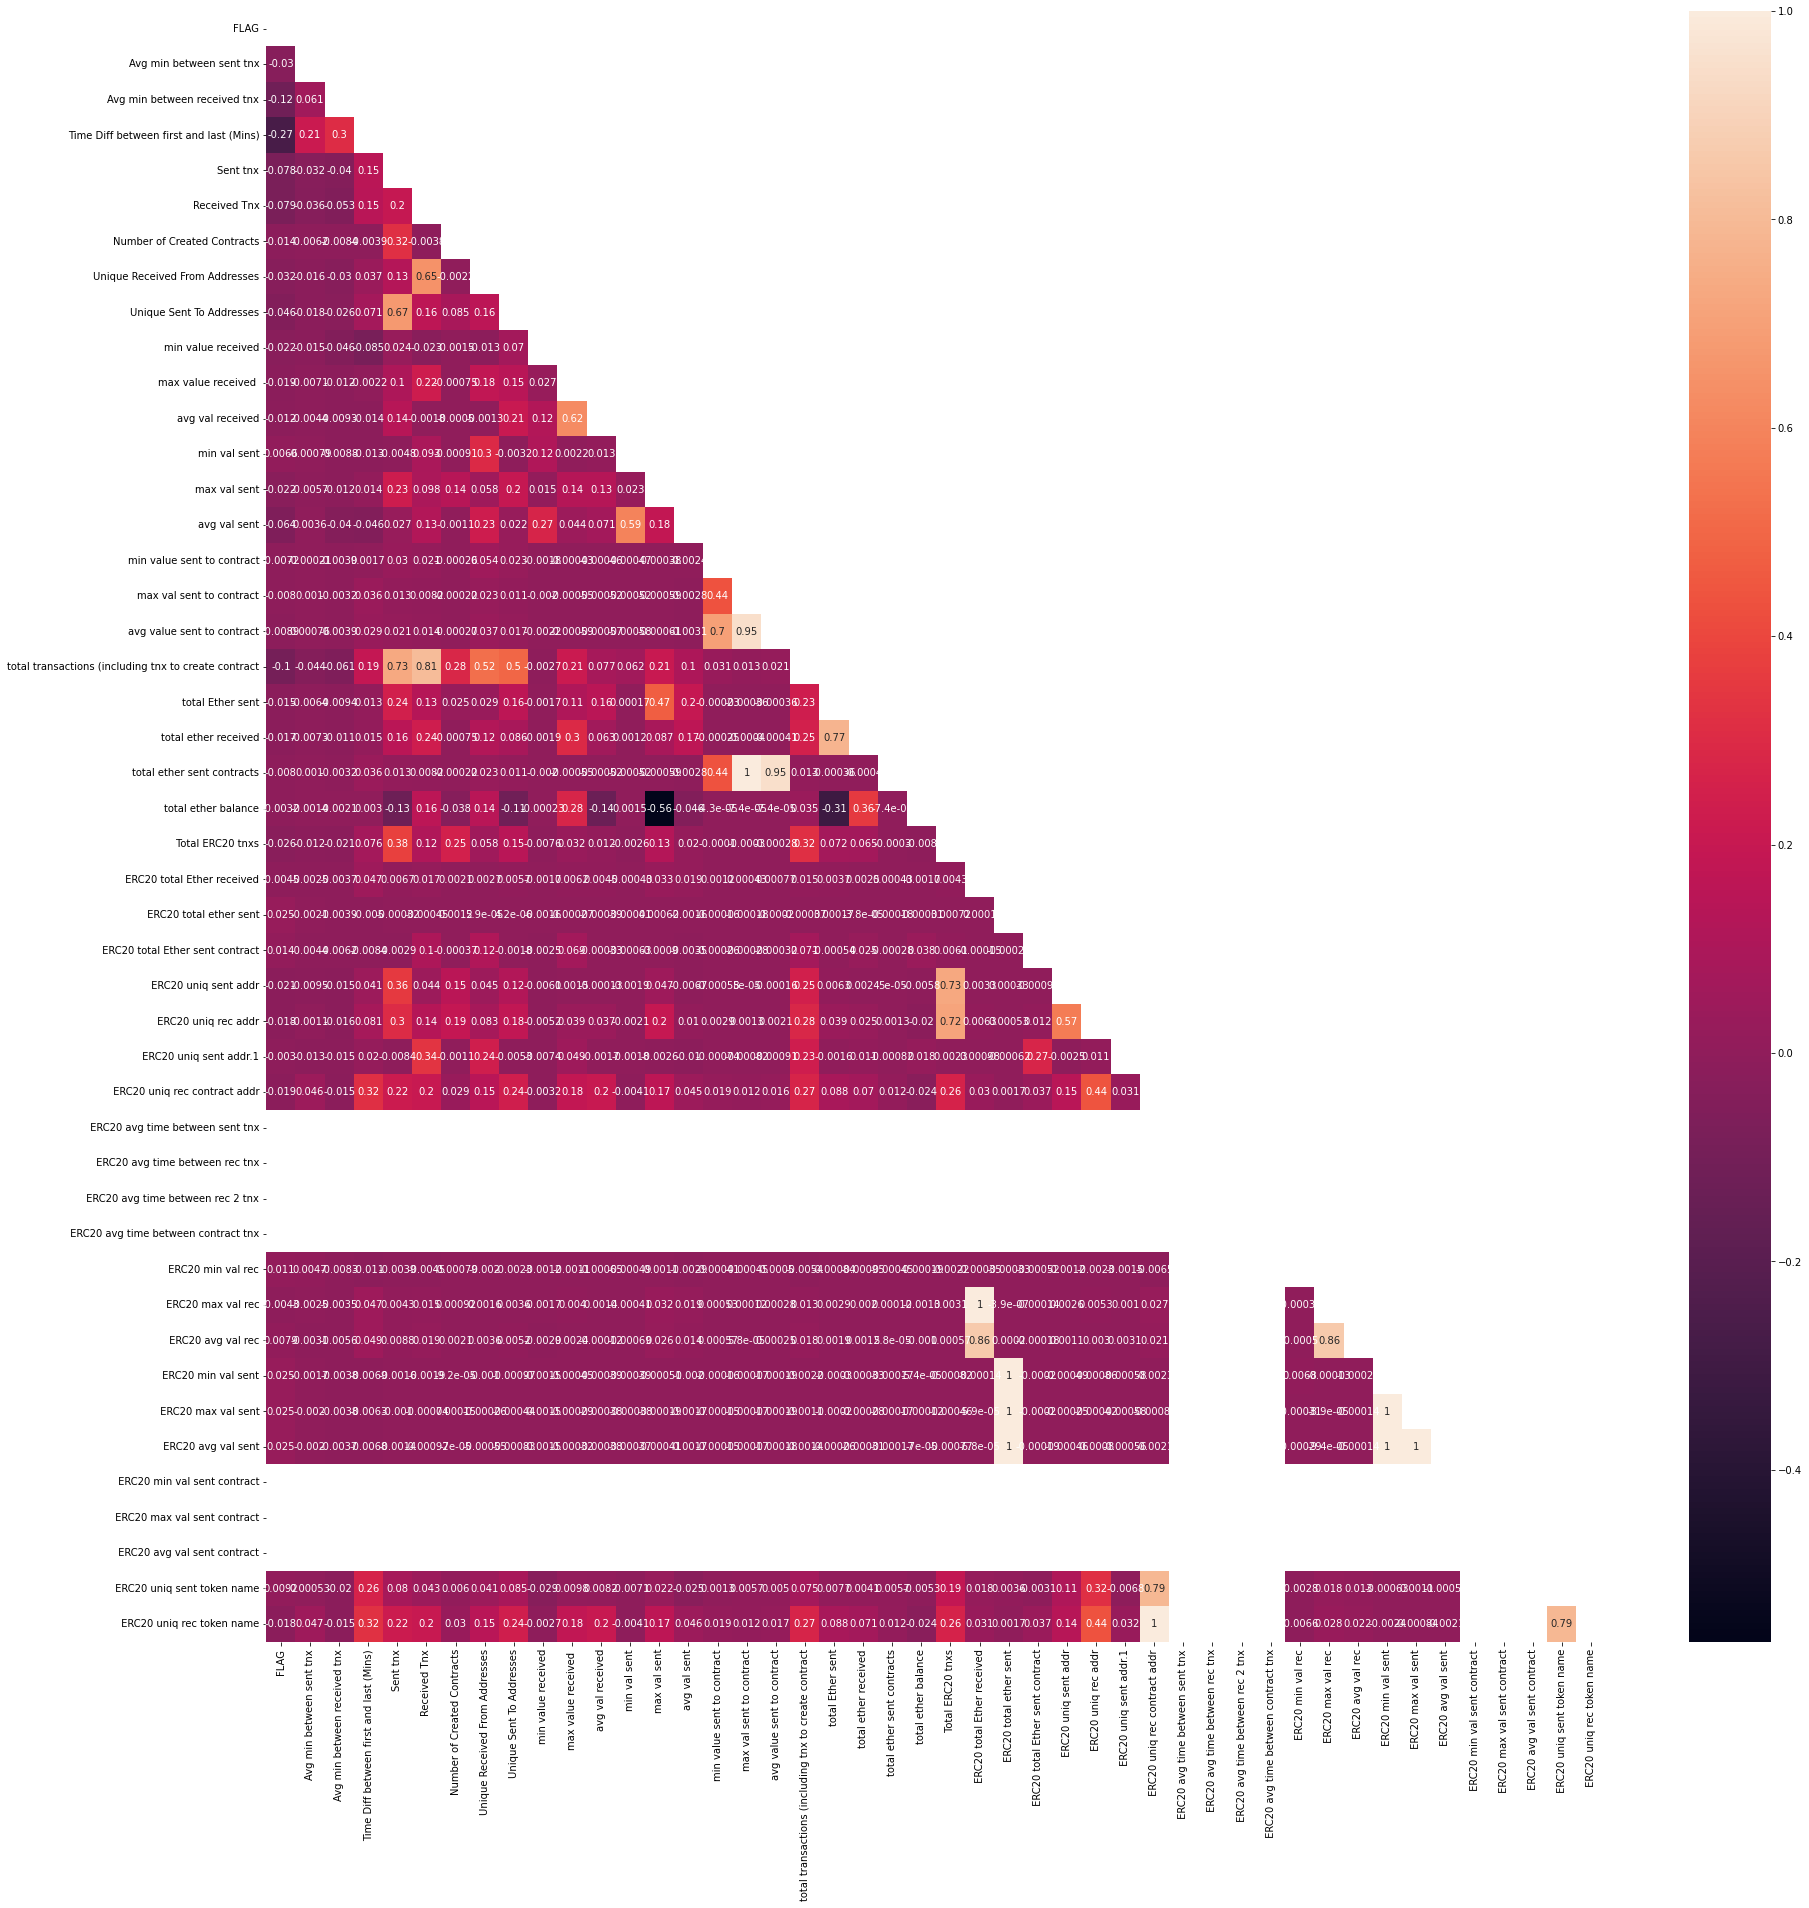

In [8]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)]=True

plt.figure(figsize=(30,30))
sns.heatmap(df.corr(), mask=mask, annot=True)

In [9]:
high_corr_colns = get_top_abs_correlations(df)
print(high_corr_colns)

max val sent to contract       total ether sent contracts    1.000000
 ERC20 total Ether received     ERC20 max val rec            0.999967
 ERC20 max val sent             ERC20 avg val sent           0.999952
 ERC20 min val sent             ERC20 avg val sent           0.999785
                                ERC20 max val sent           0.999729
 ERC20 total ether sent         ERC20 max val sent           0.999649
 ERC20 uniq rec contract addr   ERC20 uniq rec token name    0.999642
 ERC20 total ether sent         ERC20 avg val sent           0.999566
                                ERC20 min val sent           0.999311
avg value sent to contract     total ether sent contracts    0.949608
dtype: float64


In [10]:
# Find features with correlation greater than 0.95
corr_colns = [column for column in upper.columns if any(upper[column] >0.95)]
print(corr_colns)

# Drop Columns with correlation greater than 0.95
df.drop(corr_colns, axis=1, inplace=True)

['total ether sent contracts', ' ERC20 max val rec', ' ERC20 min val sent', ' ERC20 max val sent', ' ERC20 avg val sent', ' ERC20 uniq rec token name']


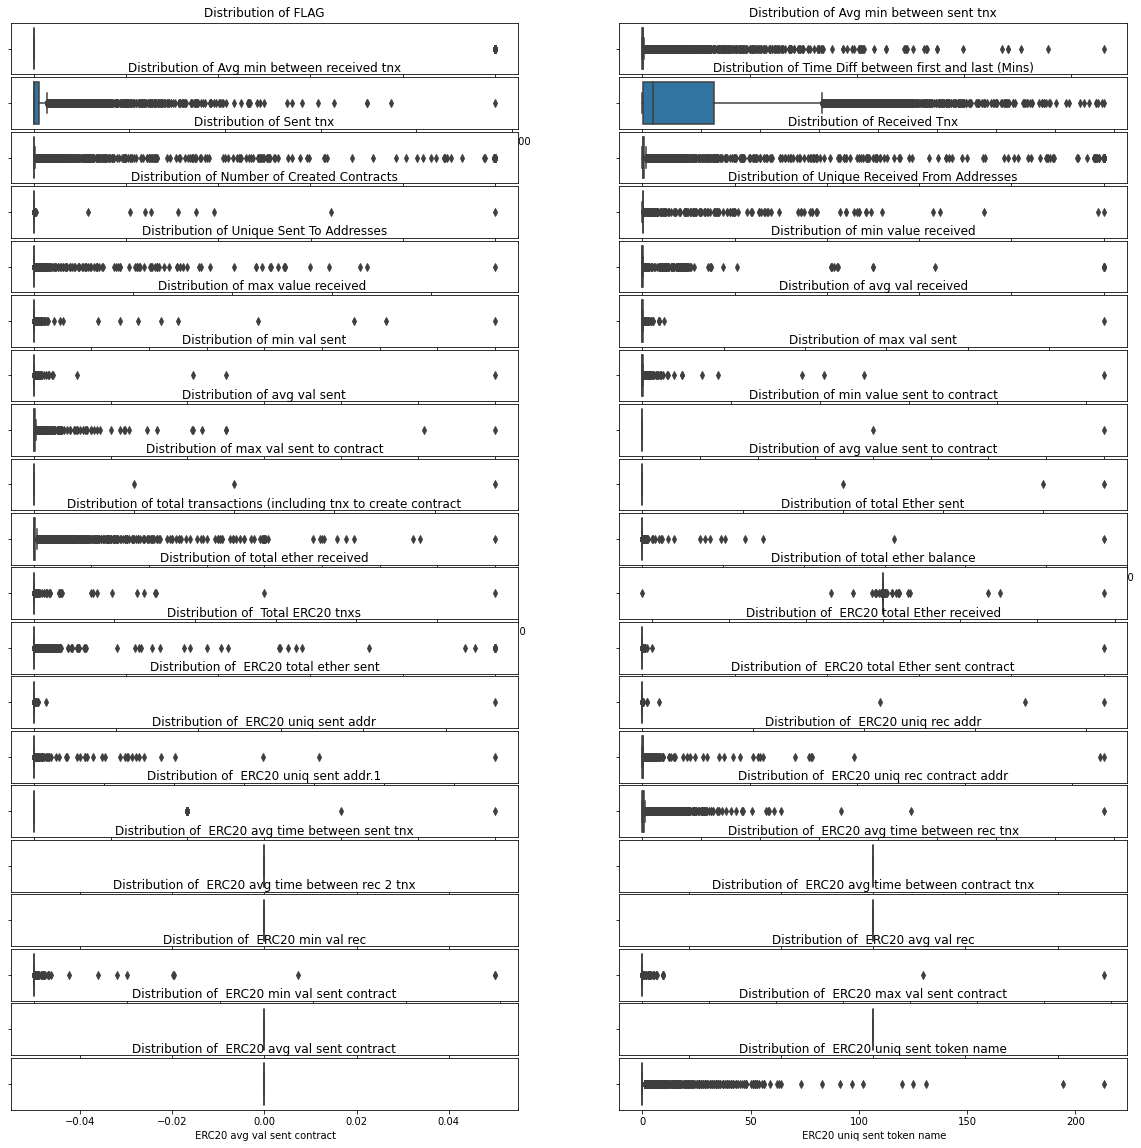

In [11]:
# Box Plot Analysis
columns = df.columns
fig, axes = plt.subplots(20, 2, figsize=(20, 20), constrained_layout =True)
plt.subplots_adjust(wspace = 0.2, hspace=0.05)

k = 0
for i in range(20):
    for j in range(2):
        sns.boxplot(ax = axes[i,j], data=df, x=columns[k]).set_title(f'Distribution of {columns[k]}')
        k = k+1

plt.show()

# 4. Data Cleaning

In [12]:
print_nan_data(df)

FLAG                                                    0.000000
Avg min between sent tnx                                0.000000
Avg min between received tnx                            0.000000
Time Diff between first and last (Mins)                 0.000000
Sent tnx                                                0.000000
Received Tnx                                            0.000000
Number of Created Contracts                             0.000000
Unique Received From Addresses                          0.000000
Unique Sent To Addresses                                0.000000
min value received                                      0.000000
max value received                                      0.000000
avg val received                                        0.000000
min val sent                                            0.000000
max val sent                                            0.000000
avg val sent                                            0.000000
min value sent to contrac

In [7]:
# Drop missing data observations/rows
df_clean = remove_nan_rows(df)
print_nan_data(df_clean)

FLAG                                                    0.0
Avg min between sent tnx                                0.0
Avg min between received tnx                            0.0
Time Diff between first and last (Mins)                 0.0
Sent tnx                                                0.0
Received Tnx                                            0.0
Number of Created Contracts                             0.0
Unique Received From Addresses                          0.0
Unique Sent To Addresses                                0.0
min value received                                      0.0
max value received                                      0.0
avg val received                                        0.0
min val sent                                            0.0
max val sent                                            0.0
avg val sent                                            0.0
min value sent to contract                              0.0
max val sent to contract                

In [14]:
# Drop missing data features/columns
# df_clean = remove_nan_columns(df)

In [15]:
# Removing features with 0 variance
print(df_clean.shape)
df_clean.drop(df_clean.var()[no_var].index, axis = 1, inplace = True)
print(df_clean.var())
print(df_clean.shape)

(9012, 40)
FLAG                                                    1.273743e-01
Avg min between sent tnx                                4.900880e+08
Avg min between received tnx                            5.609860e+08
Time Diff between first and last (Mins)                 1.098688e+11
Sent tnx                                                6.248215e+05
Received Tnx                                            9.631088e+05
Number of Created Contracts                             2.184618e+04
Unique Received From Addresses                          9.729480e+04
Unique Sent To Addresses                                7.594203e+04
min value received                                      1.130904e+05
max value received                                      1.847689e+08
avg val received                                        9.085309e+06
min val sent                                            2.097398e+04
max val sent                                            4.797736e+07
avg val sent           

In [16]:
corr_matrix = df_clean.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

corr_colns = [column for column in upper.columns if any(upper[column] >0.95)]

# Drop Columns with correlation greater than 0.95
df.drop(corr_colns, axis=1, inplace=True)

[]

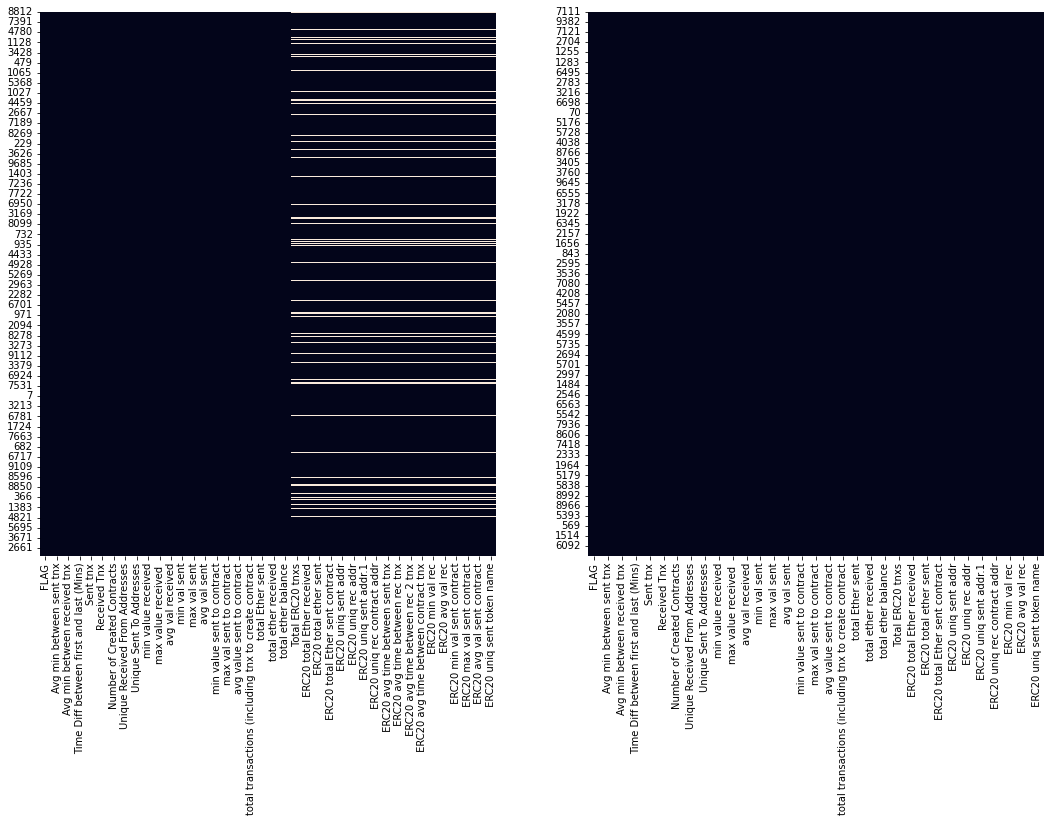

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

sns.heatmap(df.isnull(), cbar=False, ax=ax1)
sns.heatmap(df_clean.isnull(), cbar=False, ax=ax2)
ax1.plot()
ax2.plot()

[]

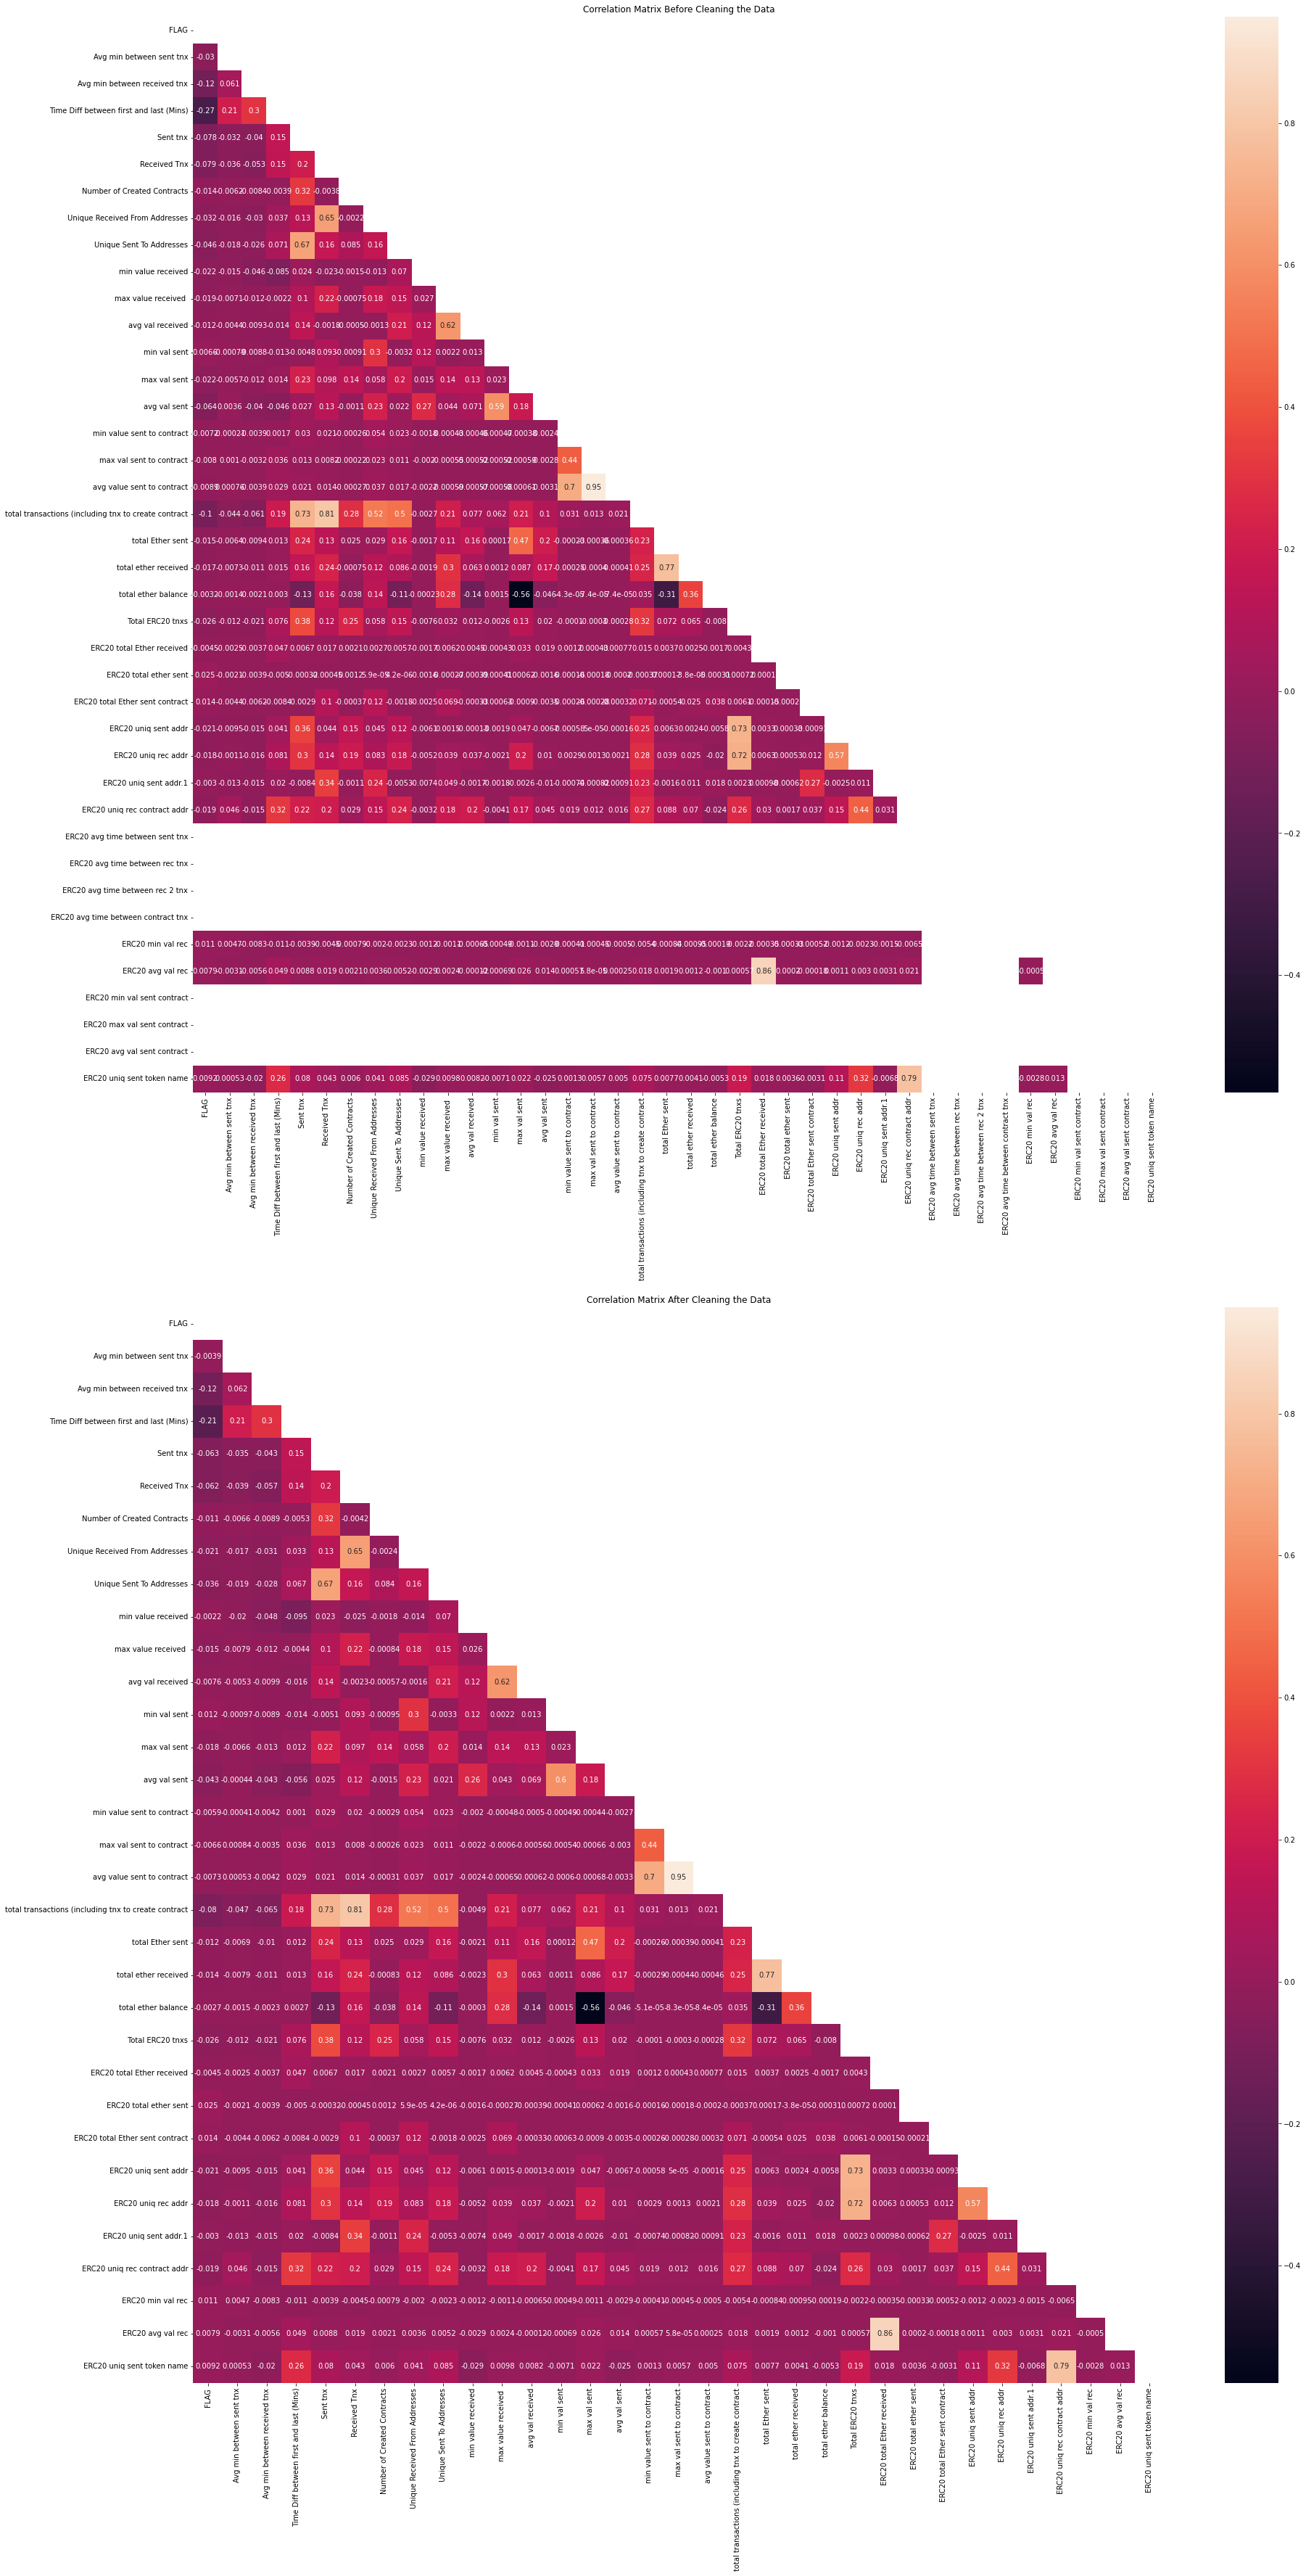

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 60))

corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)]=True

sns.heatmap(df.corr(), mask=mask, annot=True, ax=ax1)

corr_matrix = df_clean.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)]=True

sns.heatmap(df_clean.corr(), mask=mask, annot=True, ax=ax2)

ax1.set_title('Correlation Matrix Before Cleaning the Data')
ax1.plot()
ax2.set_title('Correlation Matrix After Cleaning the Data')
ax2.plot()

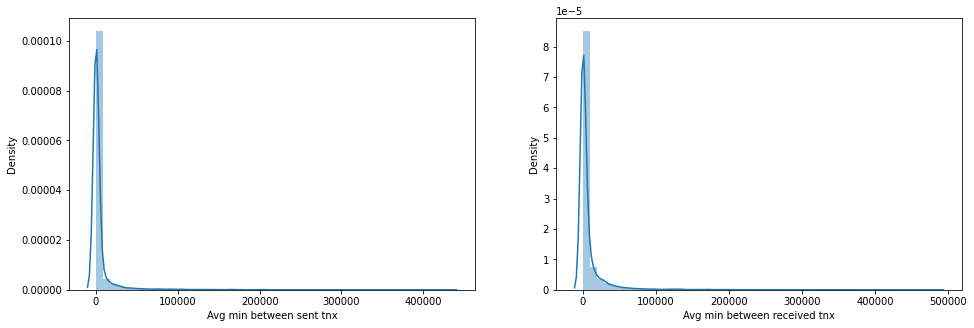

In [19]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df['Avg min between sent tnx'])
plt.subplot(1,2,2)
sns.distplot(df['Avg min between received tnx'])
plt.show()

# 5. Data Preparation

In [17]:
# Normalizae Data
df_norm = df_clean.copy()

# apply normalization techniques
for column in df_norm.columns:
    # We don't want to apply normalization on TARGET column
    if column == TARGET:
        continue
    df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())

df_norm.dropna(inplace=True, axis=1)

In [21]:
display(df_norm)

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 avg val rec,ERC20 uniq sent token name
7111,0,0.011927,7.359934e-03,0.497018,0.0134,0.0080,0.0,0.0034,0.006676,1.900000e-05,...,2.369920e-06,7.770474e-06,0.0,0.002735,0.010482,0.0,0.061381,0.000000,2.021392e-06,0.070423
6125,0,0.000008,9.025604e-02,0.066791,0.0003,0.0003,0.0,0.0002,0.000108,9.990000e-05,...,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000
9282,1,0.000000,9.079474e-04,0.005194,0.0001,0.0010,0.0,0.0010,0.000108,1.000000e-06,...,1.336973e-11,0.000000e+00,0.0,0.000000,0.000233,0.0,0.001279,0.000014,7.754406e-10,0.000000
4409,0,0.000252,0.000000e+00,0.000166,0.0003,0.0001,0.0,0.0001,0.000215,1.010000e-02,...,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000
2002,0,0.011995,1.321052e-02,0.107749,0.0026,0.0012,0.0,0.0003,0.001400,1.000000e-08,...,3.169224e-10,2.678571e-09,0.0,0.000304,0.001631,0.0,0.007673,0.000000,1.838141e-09,0.009390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3477,0,0.000007,8.710522e-07,0.000005,0.0003,0.0002,0.0,0.0002,0.000323,5.620723e-02,...,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000
488,0,0.007873,9.738467e-02,0.154520,0.0006,0.0006,0.0,0.0004,0.000323,0.000000e+00,...,2.799844e-08,2.446339e-07,0.0,0.000304,0.000466,0.0,0.002558,0.000606,8.119507e-07,0.004695
3667,0,0.000000,0.000000e+00,0.000001,0.0001,0.0001,0.0,0.0001,0.000108,2.049870e-03,...,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000
816,0,0.000000,0.000000e+00,0.000000,0.0000,0.0001,0.0,0.0001,0.000000,3.308700e-06,...,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000


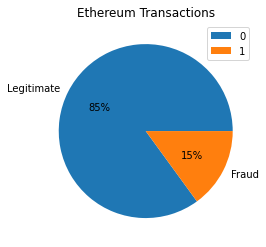

In [14]:
flag_counts = df_norm[TARGET].value_counts()

plt.pie(flag_counts, labels={'Fraud', 'Legitimate'}, autopct='%.0f%%')
plt.title('Ethereum Transactions')
plt.legend(flag_counts.keys().tolist())
plt.show()

# 6. Sampling

## Method 1. SMOTE Sampling

In [10]:
from utils.sampling import smote

df_smote = df_norm.copy()

X = df_smote.drop(TARGET, axis=1)
y = df_smote[TARGET]
X_res, y_res = smote(X, y, verbose=True)
df_smote = pd.concat([X_res, y_res], axis=1)
display(df_smote.head())

Original Data Distribution:  Counter({0: 7662, 1: 1350})
Data Distribution After SMOTE:  Counter({1: 7662, 0: 7662})


,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,...,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 uniq sent token name,ERC20 uniq rec token name,FLAG
0,0.000633,3.027943e-06,0.000705,0.0005,0.0010,0.0000,0.0002,0.000538,0.000000,0.000004,...,0.001279,0.000014,1.337000e-11,7.754406e-10,0.0,0.0,0.0,0.0,0.001357,1
1,0.000253,0.000000e+00,0.000167,0.0003,0.0001,0.0000,0.0001,0.000215,0.010100,0.000126,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0
2,0.000377,6.843981e-07,0.000166,0.0002,0.0002,0.0000,0.0002,0.000215,0.001367,0.000109,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0
3,0.000041,4.788920e-04,0.303434,0.2377,0.2386,0.0000,0.0004,0.000323,0.000010,0.000128,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0
4,0.000000,1.720743e-04,0.000085,0.0000,0.0002,0.0001,0.0002,0.000000,0.000415,0.000006,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0


## Method 2. 3-Way cross validation

3-way corss validation is implemented within the GMM model.

# 7. Modeling

## Model 1. Supervised: Random Forest

Highest Accuracy At Depth:  21


1it [00:01,  1.53s/it]

AUPRC: 0.999604434885671
F1 score:  0.9914642153644124 

              precision    recall  f1-score   support

      normal       0.99      0.99      0.99      1539
       fraud       0.99      0.99      0.99      1526

    accuracy                           0.99      3065
   macro avg       0.99      0.99      0.99      3065
weighted avg       0.99      0.99      0.99      3065

Confusion Matrix: [tn, fp, fn, tp] =  [1529   10   16 1510]


2it [00:03,  1.53s/it]

AUPRC: 0.9994103292091994
F1 score:  0.9882812499999999 

              precision    recall  f1-score   support

      normal       0.99      0.99      0.99      1530
       fraud       0.99      0.99      0.99      1535

    accuracy                           0.99      3065
   macro avg       0.99      0.99      0.99      3065
weighted avg       0.99      0.99      0.99      3065

Confusion Matrix: [tn, fp, fn, tp] =  [1511   19   17 1518]


3it [00:04,  1.52s/it]

AUPRC: 0.998997442001731
F1 score:  0.9863636363636364 

              precision    recall  f1-score   support

      normal       0.99      0.98      0.99      1528
       fraud       0.98      0.99      0.99      1537

    accuracy                           0.99      3065
   macro avg       0.99      0.99      0.99      3065
weighted avg       0.99      0.99      0.99      3065

Confusion Matrix: [tn, fp, fn, tp] =  [1504   24   18 1519]


4it [00:06,  1.52s/it]

AUPRC: 0.9994581443210866
F1 score:  0.9912593072191649 

              precision    recall  f1-score   support

      normal       1.00      0.99      0.99      1528
       fraud       0.99      1.00      0.99      1537

    accuracy                           0.99      3065
   macro avg       0.99      0.99      0.99      3065
weighted avg       0.99      0.99      0.99      3065

Confusion Matrix: [tn, fp, fn, tp] =  [1507   21    6 1531]


5it [00:07,  1.51s/it]

AUPRC: 0.9995024579451192
F1 score:  0.9921414538310412 

              precision    recall  f1-score   support

      normal       0.99      0.99      0.99      1537
       fraud       0.99      0.99      0.99      1527

    accuracy                           0.99      3064
   macro avg       0.99      0.99      0.99      3064
weighted avg       0.99      0.99      0.99      3064

Confusion Matrix: [tn, fp, fn, tp] =  [1525   12   12 1515]
Token Counts accuracy score:  0.989885296385111
Token Counts precision score:  0.9888231439222812
Token Counts recall score:  0.9909933546511516
Token Counts f1 score:  0.989901972555651
Token Counts aurpc score:  0.9993945616725612


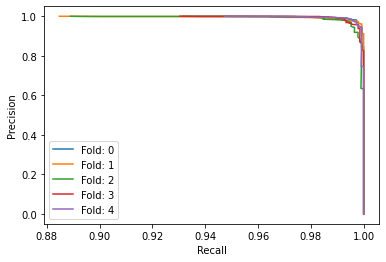

In [24]:
df_rfm = df_smote.copy()
rfm = Random_Forest_Model(df_rfm)
rfm.set_max_depth(100)
efm.add_model(rfm)
efm.run_model(model_name='RandomForest')

## Model 2. Supervised: Logistic Regression

Model Name:  Logistic Regression
Fold: 0
Accuracy Score:  0.6812398042414356
AUPRC: 0.7614660545924654
F1 score:  0.7375772226698898 

Fold: 1
Accuracy Score:  0.6920065252854812
AUPRC: 0.7595436383802598
F1 score:  0.7382140876317249 

Fold: 2
Accuracy Score:  0.6877650897226754
AUPRC: 0.7539791931675526
F1 score:  0.7355623100303952 

Fold: 3
Accuracy Score:  0.6809135399673736
AUPRC: 0.7297145623826027
F1 score:  0.7241962774957699 

Fold: 4
Accuracy Score:  0.683420365535248
AUPRC: 0.7350382943846959
F1 score:  0.7298050139275767 



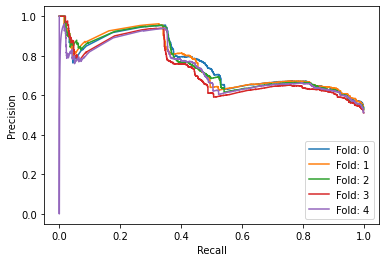

Token Counts accuracy score:  0.6850690649504427
Token Counts precision score:  0.6360031333035379
Token Counts recall score:  0.8651562532567013
Token Counts f1 score lbfgs:  0.7330709823510713
Token Counts aurpc score:  0.7479483485815154


In [25]:
df_lr = df_smote.copy()
df_lr = shuffle(df_lr)
lr = Logistic_Regression_Model(df_lr)
lr.run()

## Model 3. Supervised: Support Vector Machine (SVM)

Model Name:  SVM
Accuracy: 0.7066884176182708
F1 score: 0.7499304589707928
AUPRC: 0.814602107254841
Accuracy: 0.73278955954323
F1 score: 0.7764127764127764
AUPRC: 0.8289941743422757
Accuracy: 0.7066884176182708
F1 score: 0.7504857063558146
AUPRC: 0.8391905716426614
Accuracy: 0.7380097879282218
F1 score: 0.771420438371762
AUPRC: 0.8371298664355001
Accuracy: 0.7199738903394256
F1 score: 0.7632450331125827
AUPRC: 0.8461617088928348


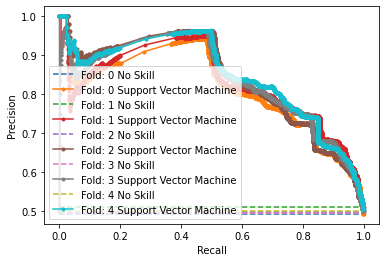

Token Counts accuracy score:  0.7208300146094838
Token Counts precision score:  0.6638090147467348
Token Counts recall score:  0.8952446029237819
Token Counts f1 score:  0.7622988826447458
Token Counts aurpc score:  0.8332156857136226


In [26]:
from sklearn import svm

df_svm = df_smote.copy()
svm_model = SVM_Model(df_svm)
svm_model.run()

## Model 4. GMM

Threshold range: -548.787, 95.133


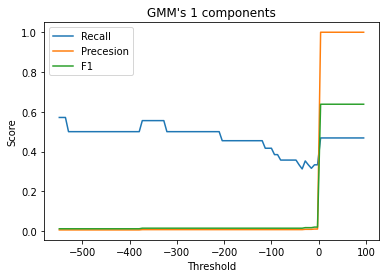

Optimal threshold: 4.073
Recall score: 1.000
Precision score: 0.468
F1 Score: 0.638
Accuracy: 0.468
Threshold range: -94.441, 149.829


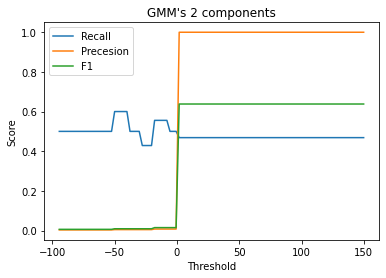

Optimal threshold: 1.787
Recall score: 1.000
Precision score: 0.468
F1 Score: 0.638
Accuracy: 0.468
Threshold range: -9.276, 158.873


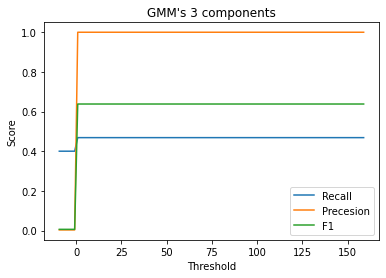

Optimal threshold: 0.915
Recall score: 1.000
Precision score: 0.468
F1 Score: 0.638
Accuracy: 0.468


In [33]:
gmm_model = GMM_Model(df_norm)
gmm_model.run(verbose=False)

## Principal Component Analysis

In [10]:
pca_transformer = PCA_Transformer(df_smote)
pca_transformer.set_n_components(10)
df_pca = pca_transformer.run()

display(df_pca)

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,FLAG
0,-0.526657,-0.048537,0.005922,-0.032187,0.196710,0.304445,0.002313,-0.019987,0.050221,-0.083083,0
1,-0.625152,-0.028704,-0.013310,-0.041638,0.098497,0.238579,0.175384,0.211004,0.767559,0.563395,1
2,-0.121299,-0.093409,0.065888,0.151429,-0.426474,-0.069000,-0.763770,-1.675124,-3.751097,-3.830928,0
3,-0.499024,-0.048202,0.002611,-0.033618,0.243795,0.237021,0.086784,0.076576,0.035132,-0.117017,0
4,-0.018932,-0.085452,0.067993,0.155338,-0.391183,-0.081438,-0.733228,-1.494392,-3.305791,-3.246767,0
...,...,...,...,...,...,...,...,...,...,...,...
15319,-0.624964,-0.028775,-0.013564,-0.041940,0.103355,0.233052,0.181225,0.220642,0.759153,0.556132,1
15320,-0.627911,-0.028704,-0.013511,-0.041916,0.097975,0.239882,0.178589,0.212834,0.772744,0.565853,1
15321,-0.591600,-0.028037,-0.012894,-0.044736,0.133239,0.229760,0.151933,0.221398,0.750461,0.576866,1
15322,-0.621005,-0.028674,-0.013345,-0.042233,0.102527,0.237503,0.173194,0.211186,0.761705,0.560501,1


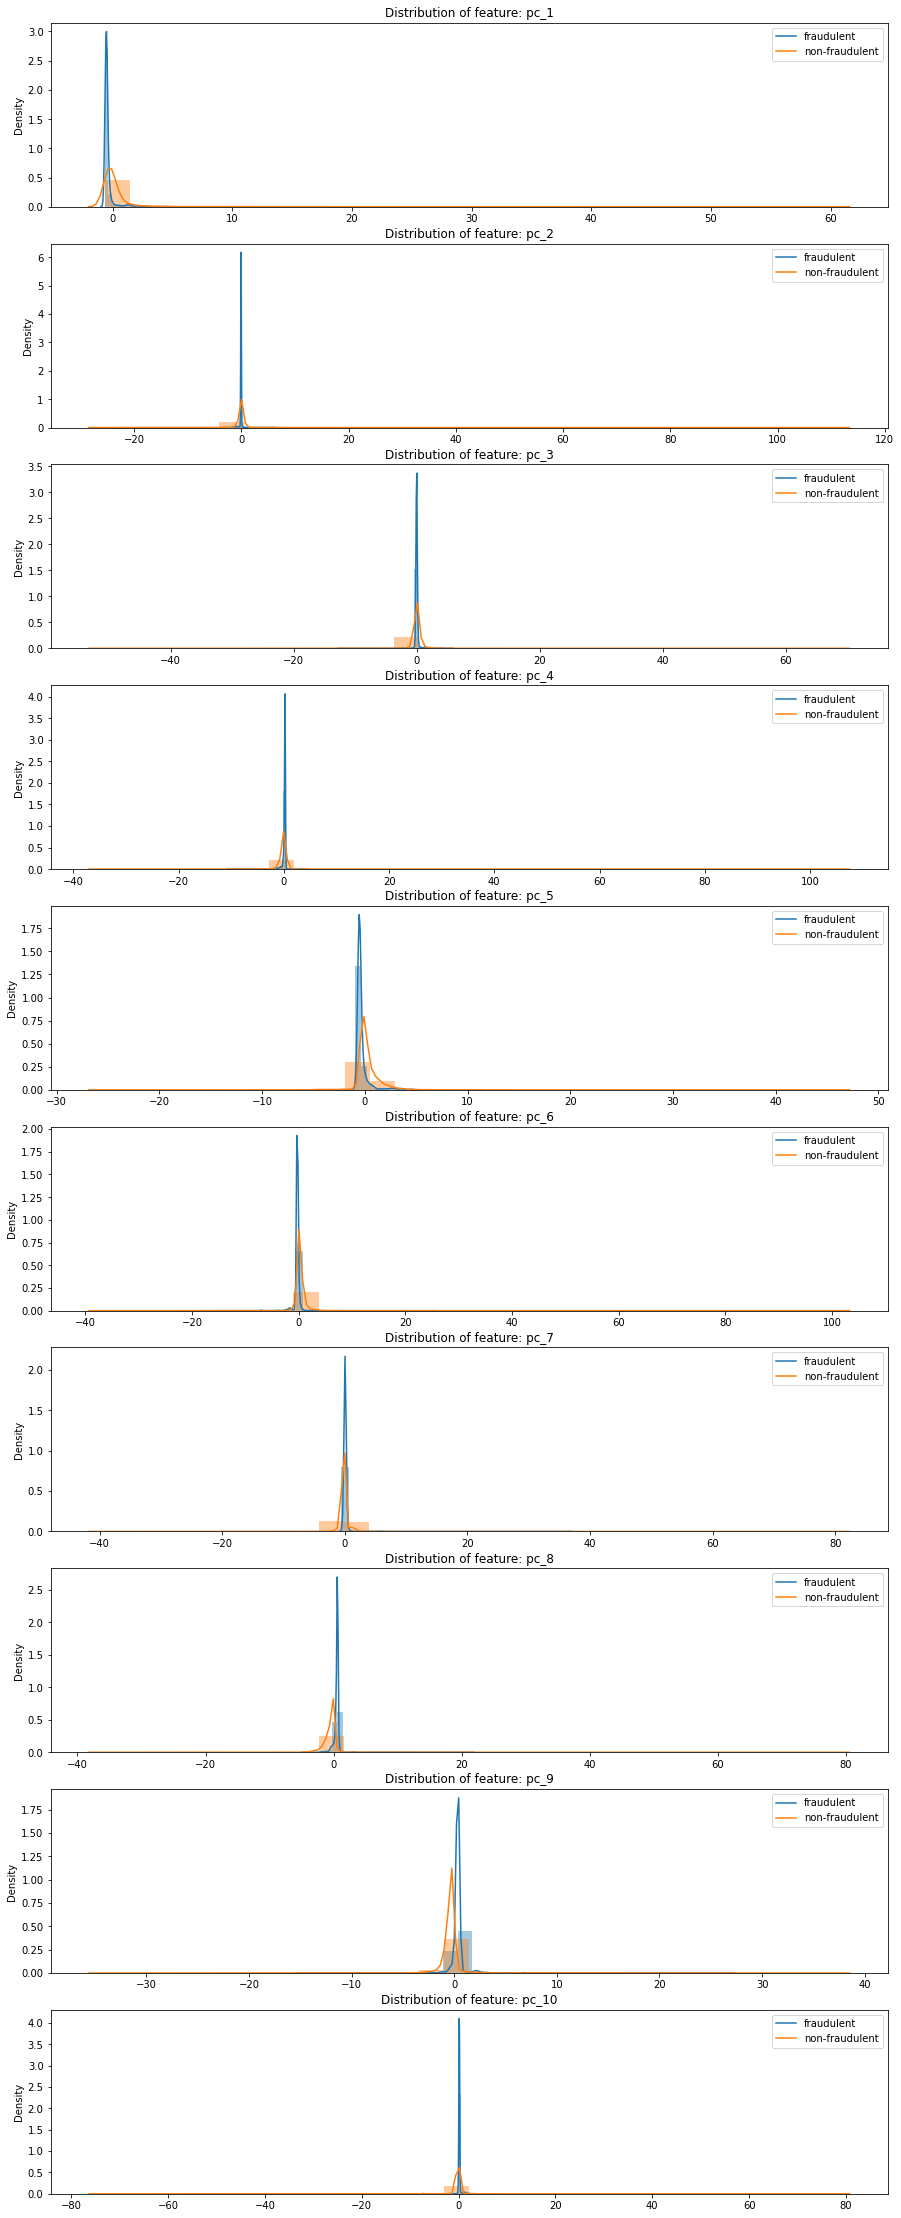

In [27]:
import matplotlib.gridspec as gridspec

features = df_pca.columns

nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    if feat == TARGET:
        continue
    ax = plt.subplot(gs[i])
    sns.distplot(df_pca[feat][df_pca.FLAG==1], bins=30)
    sns.distplot(df_pca[feat][df_pca.FLAG==0], bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

## (Modeling After PCA Transformation)

## Model 1. Supervised: Random Forest

Highest Accuracy At Depth:  38


1it [00:01,  1.53s/it]

AUPRC: 0.9999905129825072
F1 score:  0.99867197875166 

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1559
       fraud       1.00      1.00      1.00      1506

    accuracy                           1.00      3065
   macro avg       1.00      1.00      1.00      3065
weighted avg       1.00      1.00      1.00      3065

Confusion Matrix: [tn, fp, fn, tp] =  [1557    2    2 1504]


2it [00:03,  1.52s/it]

AUPRC: 0.9999853814498131
F1 score:  0.9980211081794196 

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1548
       fraud       1.00      1.00      1.00      1517

    accuracy                           1.00      3065
   macro avg       1.00      1.00      1.00      3065
weighted avg       1.00      1.00      1.00      3065

Confusion Matrix: [tn, fp, fn, tp] =  [1546    2    4 1513]


3it [00:04,  1.51s/it]

AUPRC: 0.99998461292106
F1 score:  0.9986893840104849 

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1539
       fraud       1.00      1.00      1.00      1526

    accuracy                           1.00      3065
   macro avg       1.00      1.00      1.00      3065
weighted avg       1.00      1.00      1.00      3065

Confusion Matrix: [tn, fp, fn, tp] =  [1537    2    2 1524]


4it [00:06,  1.51s/it]

AUPRC: 0.9995803889785269
F1 score:  0.9970750731231719 

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1525
       fraud       1.00      1.00      1.00      1540

    accuracy                           1.00      3065
   macro avg       1.00      1.00      1.00      3065
weighted avg       1.00      1.00      1.00      3065

Confusion Matrix: [tn, fp, fn, tp] =  [1522    3    6 1534]


5it [00:07,  1.51s/it]

AUPRC: 0.9995854327725349
F1 score:  0.9968213604577241 

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1491
       fraud       1.00      1.00      1.00      1573

    accuracy                           1.00      3064
   macro avg       1.00      1.00      1.00      3064
weighted avg       1.00      1.00      1.00      3064

Confusion Matrix: [tn, fp, fn, tp] =  [1486    5    5 1568]
Token Counts accuracy score:  0.9978464428249545
Token Counts precision score:  0.9981821473890238
Token Counts recall score:  0.9975299672398353
Token Counts f1 score:  0.997855780904492
Token Counts aurpc score:  0.9998252658208884


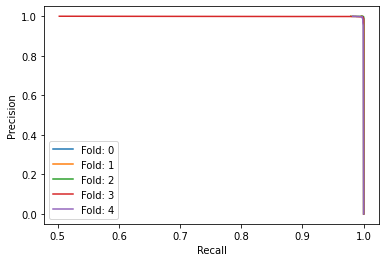

In [28]:
df_rfm_pca = df_pca.copy()
rfm = Random_Forest_Model(df_rfm_pca)
rfm.set_max_depth(100)
efm.add_model(rfm)
efm.run_model(model_name='RandomForest')

## Model 2. Supervised: Logistic Regression

Model Name:  Logistic Regression
Fold: 0
Accuracy Score:  0.964110929853181
AUPRC: 0.9745235441036457
F1 score:  0.9624829467939973 

Fold: 1
Accuracy Score:  0.9621533442088092
AUPRC: 0.9701135176976543
F1 score:  0.9607843137254901 

Fold: 2
Accuracy Score:  0.9595432300163133
AUPRC: 0.961953894741398
F1 score:  0.9587765957446809 

Fold: 3
Accuracy Score:  0.9637846655791191
AUPRC: 0.9733169268140018
F1 score:  0.9622063329928499 

Fold: 4
Accuracy Score:  0.9611618798955613
AUPRC: 0.9816643643060744
F1 score:  0.96 



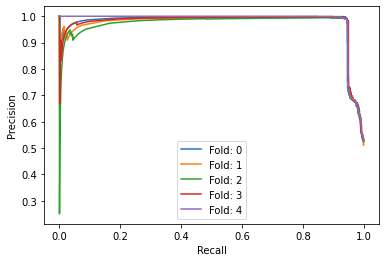

Token Counts accuracy score:  0.9621508099105969
Token Counts precision score:  0.9954023131514201
Token Counts recall score:  0.9286174712196692
Token Counts f1 score lbfgs:  0.9608500378514038
Token Counts aurpc score:  0.9723144495325549


In [29]:
df_lr_pca = df_pca.copy()
df_lr_pca = shuffle(df_lr_pca)
lr = Logistic_Regression_Model(df_lr_pca)
lr.run()

## Model 3. Supervised: Support Vector Machine (SVM)

Model Name:  SVM
Fold: 0
Accuracy: 0.9905383360522023
F1 score: 0.9904195573174761
AUPRC: 0.9986318053456239
Fold: 1
Accuracy: 0.9908646003262642
F1 score: 0.9907834101382488
AUPRC: 0.9990844725197822
Fold: 2
Accuracy: 0.9921696574225123
F1 score: 0.9923809523809525
AUPRC: 0.9991835573065595
Fold: 3
Accuracy: 0.9902120717781403
F1 score: 0.9900398406374502
AUPRC: 0.9988578407439678
Fold: 4
Accuracy: 0.9895561357702349
F1 score: 0.9893617021276596
AUPRC: 0.9982775862543101


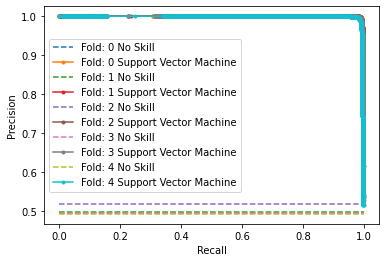

Token Counts accuracy score:  0.9906681602698708
Token Counts precision score:  0.9964111598040851
Token Counts recall score:  0.9848581759081398
Token Counts f1 score:  0.9905970925203574
Token Counts aurpc score:  0.9988070524340487


In [30]:
df_svm_pca = df_pca.copy()
svm_model = SVM_Model(df_svm_pca)
svm_model.run()

## Model 3. Unsupervised: GMM

Threshold range: -170.997, 38.257


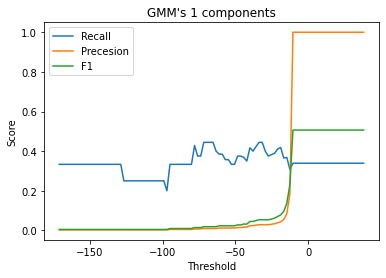

Optimal threshold: -10.358
Recall score: 1.000
Precision score: 0.339
F1 Score: 0.506
Accuracy: 0.339
Threshold range: -139.178, 54.430


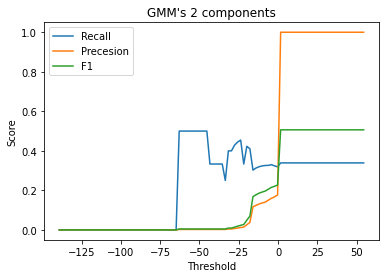

Optimal threshold: 1.627
Recall score: 1.000
Precision score: 0.339
F1 Score: 0.506
Accuracy: 0.339
Threshold range: -138.532, 60.759


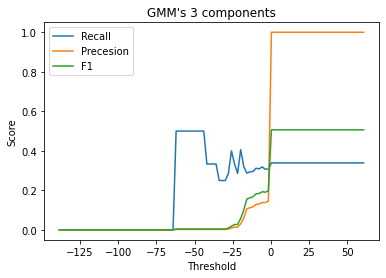

Optimal threshold: 0.368
Recall score: 1.000
Precision score: 0.339
F1 Score: 0.506
Accuracy: 0.339


In [16]:
# Apply PCA on normalized data
pca_transformer = PCA_Transformer(df_norm.copy())
pca_transformer.set_n_components(10)
df_pca = pca_transformer.run()

# Use GMM
gmm_model = GMM_Model(df_pca.copy())
gmm_model.run(verbose=False)

# Optimization

Threshold range: -17.399, -12.540


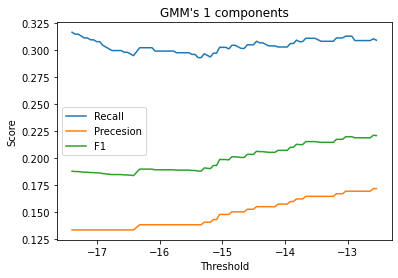

Optimal threshold: -12.589
Recall score: 0.198
Precision score: 0.346
F1 Score: 0.252
Accuracy: 0.601
Threshold range: 62.659, 69.161


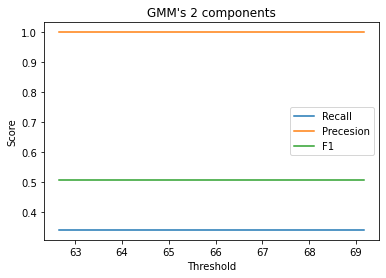

Optimal threshold: 62.659
Recall score: 1.000
Precision score: 0.339
F1 Score: 0.506
Accuracy: 0.339
Threshold range: 85.293, 89.709


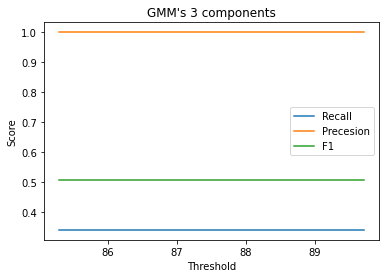

Optimal threshold: 85.293
Recall score: 1.000
Precision score: 0.339
F1 Score: 0.506
Accuracy: 0.339


In [14]:
# Apply Powertransformer
df_power = df_norm.copy().drop(TARGET, axis=1)
powerTran = PowerTransformer(method="yeo-johnson")
df_gmm = powerTran.fit_transform(df_power)
df_gmm = pd.DataFrame(df_gmm, columns=df_power.columns)
df_gmm[TARGET] = df_norm[TARGET]

# Use GMM
gmm_model = GMM_Model(df_gmm)
gmm_model.run(verbose=False)